In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2023-12-08 05:18:07.582134: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 05:18:07.582235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 05:18:07.963088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 05:18:08.978596: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 05:18:17.046444: W tensorflow/compiler/tf2

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Num GPUs Available:  1
True


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 #RGB CHANNELS

In [9]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dermnet_23/train",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dermnet_23/test",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 15557 files belonging to 23 classes.
Found 4002 files belonging to 23 classes.


In [10]:
# classes_names = dataset.class_names
# classes_names
train_dataset.class_names

['Acne and Rosacea Photos',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis Photos',
 'Bullous Disease Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Eczema Photos',
 'Exanthems and Drug Eruptions',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Herpes HPV and other STDs Photos',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Nail Fungus and other Nail Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Urticaria Hives',
 'Vascular Tumors',
 'Vasculitis Photos',
 'Warts Molluscum and other Viral Infections']

In [11]:
len(train_dataset)

487

In [40]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
(32,)
[22 22 14 18  0 23  1 19 18 16 20  9 20  3 16  5 14  5 17 16 22 16 18  5
 16 13 12 15  0 22  0 16]


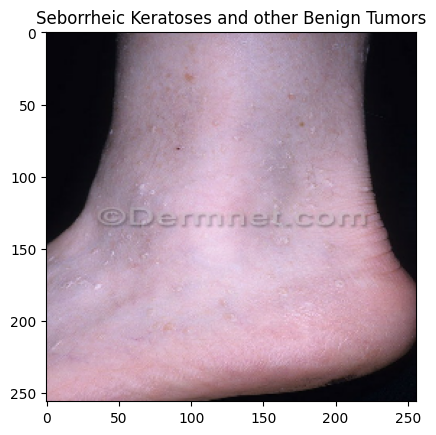

In [41]:
#how to visualize the image
for image_batch,label_batch in dataset.take(1):
    #for i in range(9):
       # plt.subplot(3,3,i+1)
       # plt.imshow(image_batch[i].numpy().astype('uint8'))
       # plt.title(classes_names[label_batch[i]])
    plt.imshow(image_batch[8].numpy().astype('uint8'))
    plt.title(classes_names[label_batch[8]])

In [42]:
train_size=0.8
len(dataset)*train_size

102.4

In [43]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)#without seed it will give different 
    train_size=int(train_split*len(ds))
    val_size=int(val_split*len(ds))
    test_size=int(test_split*len(ds))
    train_ds=ds.take(train_size)
    test_ds=ds.skip(train_size)
    val_ds=test_ds.skip(val_size)
    test_ds=test_ds.skip(test_size)
    return train_ds,val_ds,test_ds

In [44]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [45]:
len(train_ds),len(val_ds),len(test_ds) 

(102, 14, 14)

In [46]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)  

In [47]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [48]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
])

In [60]:
CHANNELS=3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 26

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [50]:
#CHANNELS=3
# Define the CNN model
#model = models.Sequential([
    #resize_and_rescale,
   # data_augmentation,
    #layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    #layers.MaxPooling2D(2, 2),
    #layers.Conv2D(64, (3, 3), activation='relu'),
   # layers.MaxPooling2D(2, 2),
    #layers.Conv2D(128, (3, 3), activation='relu'),
    #layers.MaxPooling2D(2, 2),
    #layers.MaxPooling2D(2, 2),
    #layers.Flatten(),
    #layers.Dense(512, activation='relu'),
    #ayers.Dense(7, activation='softmax')
#])
#model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [61]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [62]:
#compile using optimers
model.compile(
    optimizer='adam',#optimers are used to reduce the loss by changing the weights and learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy #common loss function for multiclass classification where the labels are integers
    #loss function measures how well the model is performing and the optimer aims to minize the value
    (from_logits=False),#  if the model is not giving the probability then we set it to false
    metrics=['accuracy']
)

In [ ]:
import tensorflow as tf
print('Available GPUs:', tf.config.list_physical_devices('GPU'))

In [ ]:
if tf.config.list_physical_devices('GPU'):
    device_name = '/GPU:0'
else:
    device_name = '/CPU:0'
print('Using device:', device_name)

In [79]:
with tf.device(device_name):
    history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1 #it will show the progress bar
)

Epoch 1/20


102/102 [==============================] - 134s 1s/step - loss: 3.0145 - accuracy: 0.0954 - val_loss: 3.0046 - val_accuracy: 0.1094
Epoch 2/20
102/102 [==============================] - 145s 1s/step - loss: 3.0003 - accuracy: 0.1080 - val_loss: 2.9770 - val_accuracy: 0.1116
Epoch 3/20
102/102 [==============================] - 135s 1s/step - loss: 2.9789 - accuracy: 0.1064 - val_loss: 3.0623 - val_accuracy: 0.0871
Epoch 4/20
102/102 [==============================] - 118s 1s/step - loss: 2.9318 - accuracy: 0.1230 - val_loss: 2.9103 - val_accuracy: 0.1351
Epoch 5/20
102/102 [==============================] - 118s 1s/step - loss: 2.9027 - accuracy: 0.1433 - val_loss: 2.8607 - val_accuracy: 0.1741
Epoch 6/20
102/102 [==============================] - 112s 1s/step - loss: 2.8695 - accuracy: 0.1472 - val_loss: 2.7998 - val_accuracy: 0.1808
Epoch 7/20
102/102 [==============================] - 112s 1s/step - loss: 2.8414 - accuracy: 0.1612 - val_loss: 2.8132 - val_accuracy: 0.1786
Epoch 8/20

In [80]:
scores=model.evaluate(test_ds)

14/14 [==============================] - 6s 429ms/step - loss: 2.0822 - accuracy: 0.3594


In [81]:
scores

[2.0821704864501953, 0.359375]

In [82]:
history

In [83]:
history.history['accuracy']

[0.09539877623319626,
 0.10797546058893204,
 0.10644172132015228,
 0.12300613522529602,
 0.14325153827667236,
 0.14723926782608032,
 0.1611519604921341,
 0.179141104221344,
 0.17822085320949554,
 0.1920955926179886,
 0.205214723944664,
 0.21901839971542358,
 0.21226993203163147,
 0.23312883079051971,
 0.25,
 0.25306373834609985,
 0.277300626039505,
 0.29386502504348755,
 0.3076687157154083,
 0.31625765562057495]

In [84]:
history.params


{'verbose': 1, 'epochs': 20, 'steps': 102}

In [85]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

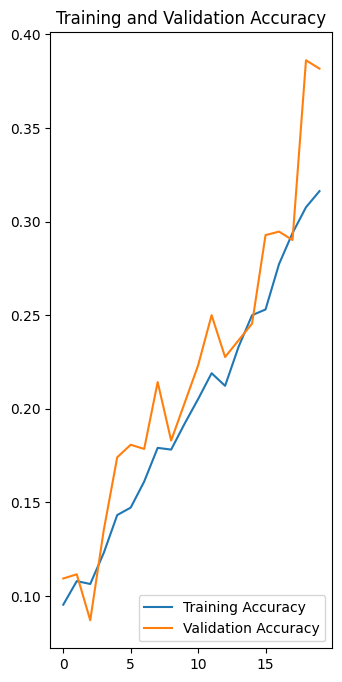

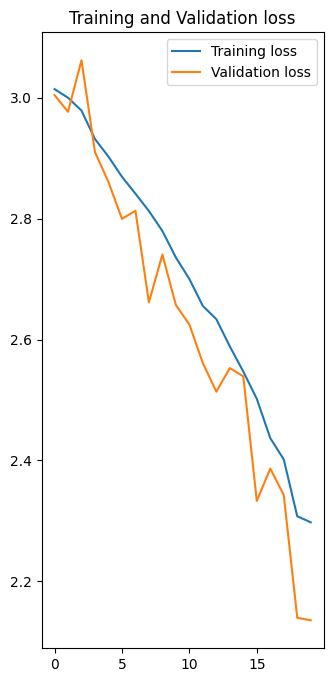

In [87]:
#chat for accuracy ,we need to see the diffrence


plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(20),acc,label='Training Accuracy')
plt.plot(range(20),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


#plot of loss basically the loss should be decrease
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(20),loss,label='Training loss')
plt.plot(range(20),val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')


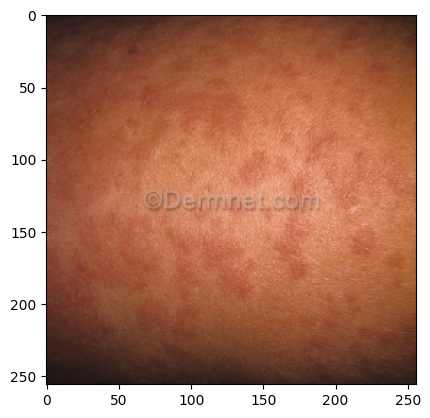

In [88]:
for image_batch, labels_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))


first image to predict
actual label Tinea Ringworm Candidiasis and other Fungal Infections
1/1 [==============================] - 0s 473ms/step
predicted label Seborrheic Keratoses and other Benign Tumors


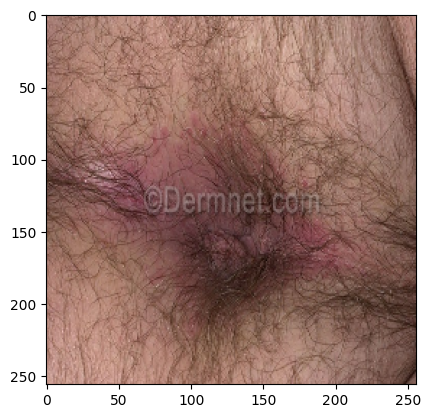

In [95]:

#we are here checking that the prediction model and the actual model are the same 


import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    first_image=image_batch[6].numpy().astype('uint8')
    first_label=labels_batch[6].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label",classes_names[first_label])
    
    #we are doing batch prediction in that i need to know only the first image
    batch_prediction=model.predict(image_batch)
    print("predicted label",classes_names[np.argmax(batch_prediction[6])])
   
    

In [91]:


#taking mode and the prediction as the input  and giving what is their class and the confidence

def predict(model,img):
    image_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(image_array,0)#cerate a batch
    prediction=model.predict(img_array)
    prediction_class=classes_names[np.argmax(prediction[0])]
    confidence=round(100*(np.max(prediction[0])),2)
    return prediction_class,confidence#it tells u abt the accuracy of the model
    
    


1/1 [==============================] - 0s 89ms/step


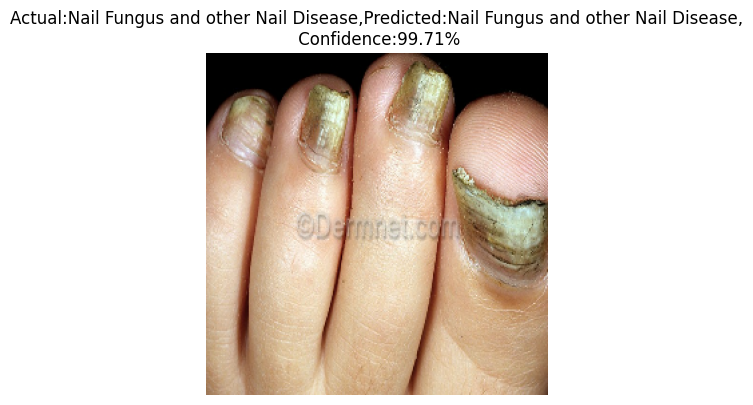

In [94]:

#we are not checking with the whole batch we are just checking with 9 images by calling the predicted function and telling how it being predicted

plt.figure(figsize=(15,20))
for images,labels in test_ds.take():
    for i in range(1):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=classes_names[labels[i]]
        #inorder to print the title we use this
        plt.title(f"Actual:{actual_class},Predicted:{predicted_class},\n Confidence:{confidence}%")
        plt.axis('off')
    

In [ ]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [ ]:
import os
os.listdir('../models')

['1']